# Practica 3 - Juan Sevilla Fernandez

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sktime.transformations.series.boxcox import LogTransformer

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/Analisis Predictivo/HW03/StackOverflow.csv")

In [44]:
matlab = data[["month", "matlab"]].copy()
matlab['month'] = pd.to_datetime(matlab['month'],format="%y-%b")
matlab = matlab.set_index('month')
matlab = matlab.resample("m").last()

In [45]:
#Preguntas por trimestre
matlab_q = matlab.resample("q").last()

In [46]:
# Log preguntas
transformer = LogTransformer()
log_matlab= transformer.fit_transform(matlab)

### 1. Analizar los datos de MATLAB, entre otros análisis, se debe graficar la serie, estudiar la estacionalidad y la estacionariedad.

In [47]:
from sktime.utils.plotting import plot_series

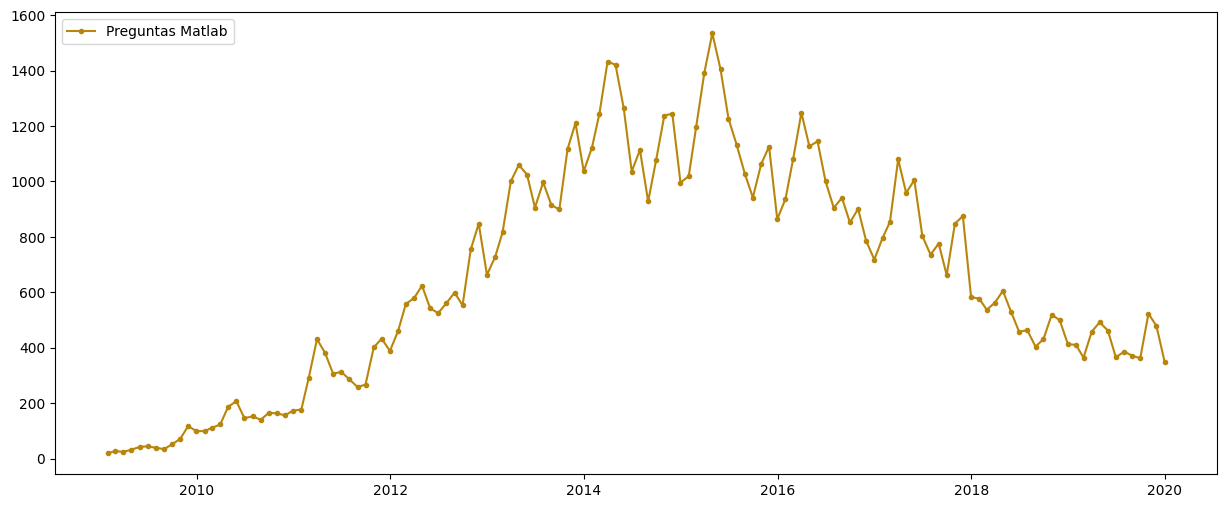

In [48]:
plt.figure(figsize=(15, 6))
plt.plot(matlab,"darkgoldenrod", label = "Preguntas Matlab", marker = ".")
plt.legend(loc="upper left");

Vemos que Matlab gana popuaridad hasta 2015, donde se observa una tendencia creciente. A medida que salen rogramas open source, la popularidad de Matlab baja desde 2015 donde se observa una tendencia bajista desde entonces.
Graficamente, se puede observar que no hay estacionariedad nie en media ni en varianza.

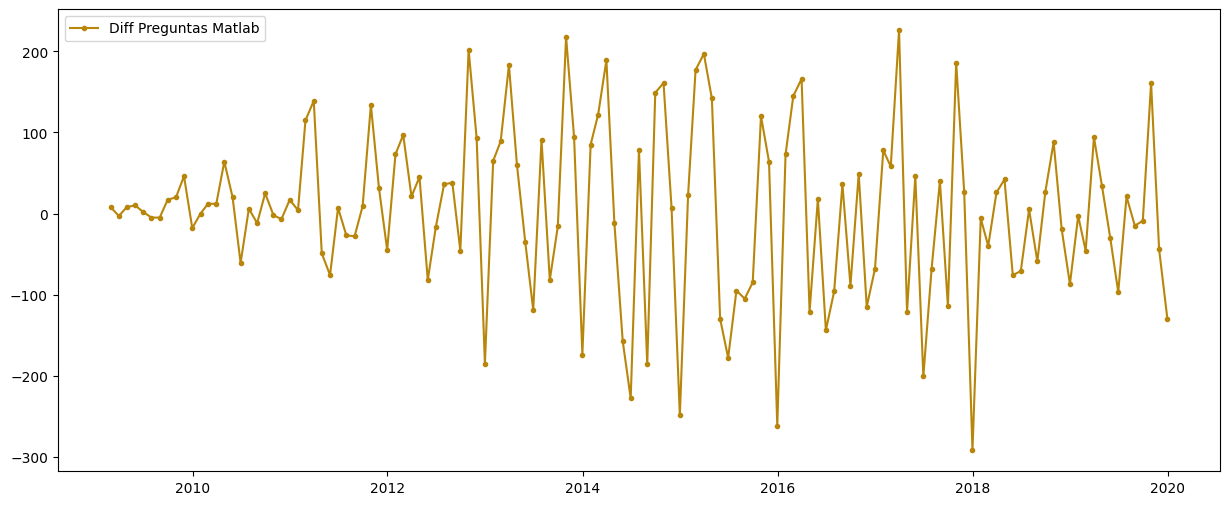

In [49]:
matlab_diff = matlab.diff().dropna()
plt.figure(figsize=(15, 6))
plt.plot(matlab_diff,"darkgoldenrod", label = "Diff Preguntas Matlab", marker = ".")
plt.legend(loc="upper left");

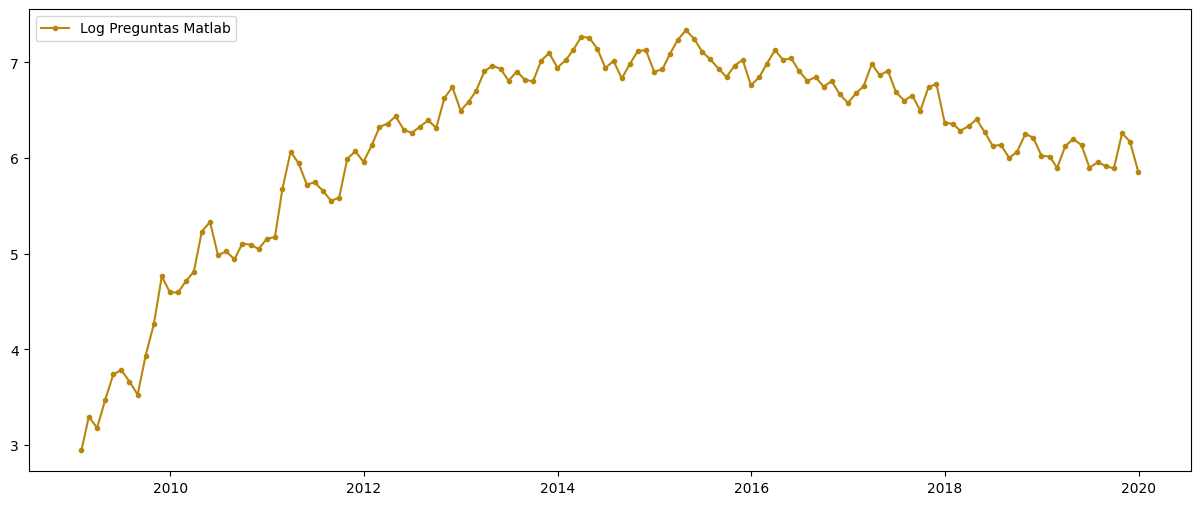

In [50]:
# plot_series(matlab, labels=["Preguntas"]);

plt.figure(figsize=(15, 6))
plt.plot(log_matlab,"darkgoldenrod", label = "Log Preguntas Matlab", marker = ".")
plt.legend(loc="upper left");

Para evitar problemas a costa de la falta de estacionariedad en media y varianza, tomamos las diferencias y los logaritmos de cada mes. Las diferencias nos otorgan estacionariedad en media y los logaritmos en varianza como se pueden ver en ambos graficos.

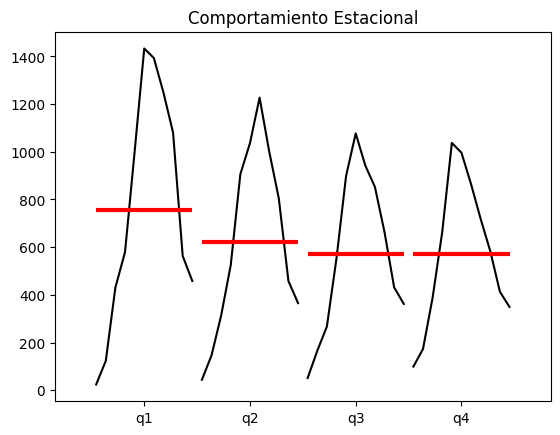

In [51]:
import statsmodels.api as sm
# Plot Quarterplot
ax = plt.gca()
sm.graphics.tsa.quarter_plot(matlab_q,ax=ax)
ax.set_title('Comportamiento Estacional');

Para ver la estacionalidad en nuestros datos, he agrupado los meses en trimestres y se puede ver como hay repuntes a principios de cada año. Esto se puede deber a que en el priemer trimetre del año es cuando alumnos de colegio/universidad comienzan a usar este programa y es cuando mas dudas tienen acerca de él.

### 2. Se debe separa la muestra en tres partes entrenamiento, validación(12 meses) y test (6 meses). Cuando no sea necesaria la validación la muestra de test debe ser de 6 meses.

In [13]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

In [52]:
n_test=6


y_train, y_test = temporal_train_test_split(y = matlab, test_size=n_test)
y_train_short, y_val = temporal_train_test_split(y =y_train, test_size=12)

log_y_train, log_y_test = temporal_train_test_split(y = log_matlab, test_size=n_test)
log_y_train_short, log_y_val = temporal_train_test_split(y =y_train, test_size=12)

y_train_diff, y_test_diff = temporal_train_test_split(y = matlab_diff, test_size=n_test)
y_train_short_diff, y_val_diff = temporal_train_test_split(y =y_train, test_size=12)


 El conjunto de train tiene: 114 filas 
 El conjunto de validacion tiene: 12 filas 
 El conjunto de test tiene: 6 filas


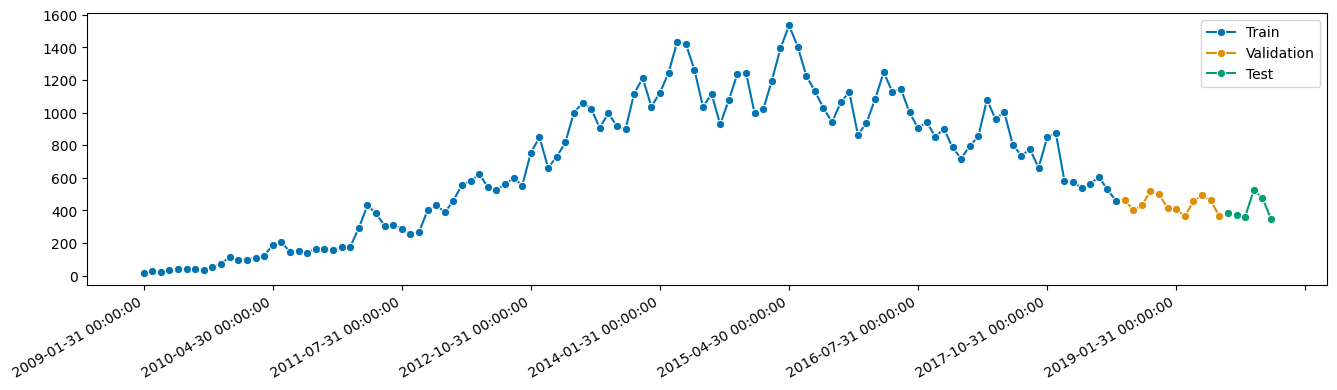

In [79]:
import matplotlib.dates as mdates
fig, ax =plot_series(y_train_short, y_val, y_test, labels=["Train", "Validation", "Test"])
fig.autofmt_xdate() 

# Time Series Size
print(
"\n El conjunto de train tiene:", str(y_train_short.shape[0]), "filas \n",
"El conjunto de validacion tiene:", str(y_val.shape[0]), "filas \n",
"El conjunto de test tiene:", str(y_test.shape[0]), "filas")

En caso de no ser necesaria la validacion, el conjunto de validacion se une al de train para entrenar el modelo.

### 3. Debemos buscar el mejor modelo predictivo entre los siguientes: 
- ETS
- ARIMA 
- 4Theta 
- TBATS

In [19]:
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.tbats import TBATS
fh = np.arange(1, 7)

### ETS

In [149]:
# Auto ETS Model
warnings.filterwarnings("ignore")
ETS_model = AutoETS(auto=True, sp=12, n_jobs=-1)
ETS_model.fit(y_train);

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

/Users/juan/opt/anaconda3/envs/AnPred/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/juan/opt/anaconda3/envs/AnPred/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


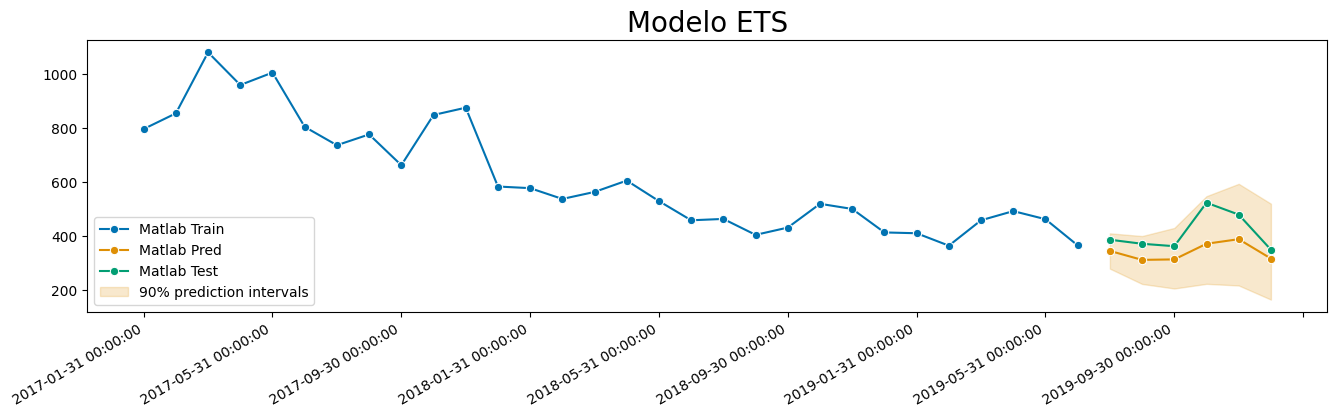

In [80]:
ets_pred = ETS_model.predict(fh)
ets_pred_ints = ETS_model.predict_interval(fh, coverage=0.9)
fig, ax = plot_series(y_train["2017-01":], ets_pred, y_test, labels=["Matlab Train", "Matlab Pred", "Matlab Test"])
fig.autofmt_xdate()
ax.fill_between(
    ax.get_lines()[-2].get_xdata(),
    ets_pred_ints[('Coverage', 0.9, 'lower')],
    ets_pred_ints[('Coverage', 0.9, 'upper')],
    alpha=0.2,
    color=ax.get_lines()[-2].get_c(),
    label=f"90% prediction intervals",
)
ax.legend(loc='lower left')
plt.title("Modelo ETS",fontsize=20);

Las predicciones del Auto ETS se quedan siempre por debajo de los valores reales. En los primeros tres meses parecen mejores resultados, pero a partir de ahi, aunque prediga el aumento por estacionalidad, la prediccion es muy conservadora comparada con la realidad.

In [24]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.transformations.series.boxcox import LogTransformer

In [25]:
mse=MeanSquaredError()
rmse = MeanSquaredError(square_root=True)

MAPE_ETS = mean_absolute_percentage_error(y_test, ets_pred)
MSE_ETS = mse(y_test, ets_pred)
RMSE_ETS = rmse(y_test, ets_pred)

lista_ETS = [MAPE_ETS,MSE_ETS,RMSE_ETS]

### ARIMA

In [27]:
#  Auto ARIMA Model with logs
forecaster = AutoARIMA(sp=12,suppress_warnings=True)
forecaster.fit(log_y_train);

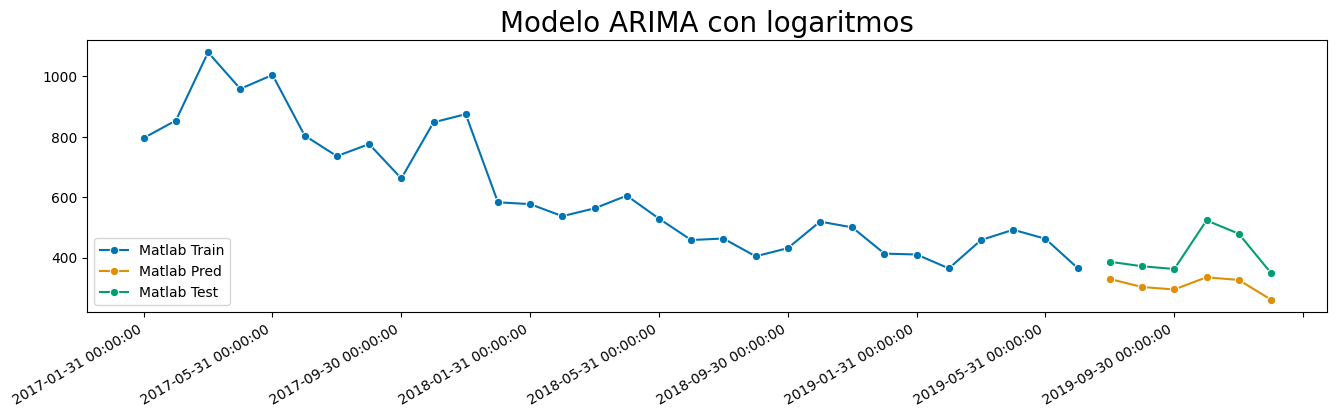

In [81]:
#  Auto ARIMA Model Summary
arima_pred = np.exp(forecaster.predict(fh))
arima_pred_ints = forecaster.predict_interval(fh, coverage=0.9)
fig, ax = plot_series(y_train["2017-01":], arima_pred, y_test, labels=["Matlab Train", "Matlab Pred", "Matlab Test"])
fig.autofmt_xdate()
ax.legend(loc='lower left')
plt.title("Modelo ARIMA con logaritmos",fontsize=20);

El modelo ARIMA ha sido calculado con el logaritmo de cada numero de preguntas, pero vemos que los resultados son bastante poco precisos. El calculo de los logaritmos es para amortiguar el error debido a la falta de estacionariedad en la varianza. Sin embargo, como hemos visto en la serie original, como la serie es alcista y luego bajista, hay mucha menos estacionariedad en la media. Es por esto por lo que entrenro un modelo de ARIMA adicional pero tomando las diferencias mes a mes.

In [97]:
MAPE_ARIMA_LOG = mean_absolute_percentage_error(y_test, arima_pred)
MSE_ARIMA_LOG = mse(y_test, arima_pred)
RMSE_ARIMA_LOG = rmse(y_test, arima_pred)

lista_ARIMA_LOG = [MAPE_ARIMA_LOG, MSE_ARIMA_LOG, RMSE_ARIMA_LOG]

In [29]:
#  Auto ARIMA Model with diffs
forecaster_diff = AutoARIMA(sp=12,suppress_warnings=True)
forecaster_diff.fit(y_train_diff);

In [32]:
arima_diff_pred = forecaster_diff.predict(fh)
arima_preds_diff = arima_diff_pred.squeeze().cumsum()+y_train["2019-06"].squeeze()

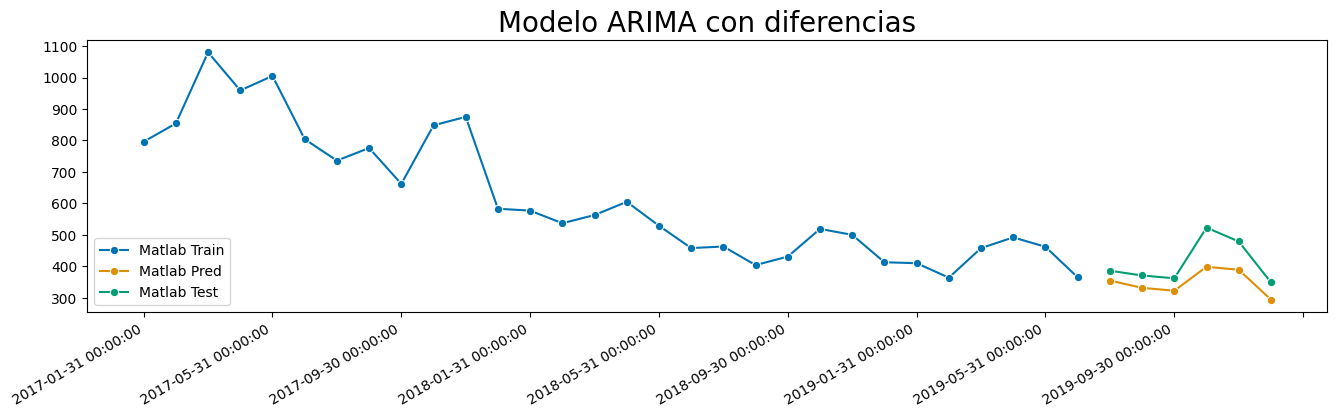

In [82]:
fig, ax = plot_series(y_train["2017-01":], arima_preds_diff, y_test, labels=["Matlab Train", "Matlab Pred", "Matlab Test"])
fig.autofmt_xdate()
ax.legend(loc='lower left')
plt.title("Modelo ARIMA con diferencias",fontsize=20);

A diferencia del ARIMA anterior, este modelo es mucho mas preciso en los tres primeros meses y capta mejor el incremento estacional en el cuato mes, pero aun asi se queda muy por debajo. En el ultimo mes, parece volver a tener una precision similar que en los primeros 3.

In [99]:
MAPE_ARIMA_DIF = mean_absolute_percentage_error(y_test, arima_preds_diff)
MSE_ARIMA_DIF = mse(y_test, arima_preds_diff)
RMSE_ARIMA_DIF = rmse(y_test, arima_preds_diff)

lista_ARIMA_DIF = [MAPE_ARIMA_DIF, MSE_ARIMA_DIF, RMSE_ARIMA_DIF]

### 4Theta

In [83]:
from darts.models import Theta, FourTheta, TBATS
from darts.metrics import mape
from darts import TimeSeries
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode

y_train_ts = TimeSeries.from_dataframe(y_train)
y_train_short_ts = TimeSeries.from_dataframe(y_train_short)
y_val_ts = TimeSeries.from_dataframe(y_val)
y_test_ts = TimeSeries.from_dataframe(y_test)

In [119]:
theta_grid = {
    'theta':2-np.linspace(0, 2, 20),
    'model_mode': [ModelMode.ADDITIVE],
    'season_mode': [SeasonalityMode.ADDITIVE],
    'trend_mode': [TrendMode.LINEAR, TrendMode.EXPONENTIAL]
}

best_grid_model=FourTheta.gridsearch(parameters=theta_grid,
                                series=y_train_short_ts,
                                forecast_horizon=12, # 12
                                start=0.5,
                                last_points_only=False,
                                metric=mape,
                                reduction=np.mean,
                                verbose=False,
                                n_jobs=-1);

In [118]:
print("Tras hacer un grid search, el mejor modelo 4Theta tiene los sguientes hiperparametros: \n"+
     "Theta:",str(round(best_grid_model[1]['theta'],2))+
     "\nModel Mode:", str(best_grid_model[1]['model_mode'])+
     "\nSeason Mode:", str(best_grid_model[1]['season_mode'])+
     "\nTrend Mode:", str(best_grid_model[1]['trend_mode']))

Tras hacer un grid search, el mejor modelo 4Theta tiene los sguientes hiperparametros: 
Theta: 0.89
Model Mode: ModelMode.ADDITIVE
Season Mode: SeasonalityMode.ADDITIVE
Trend Mode: TrendMode.EXPONENTIAL


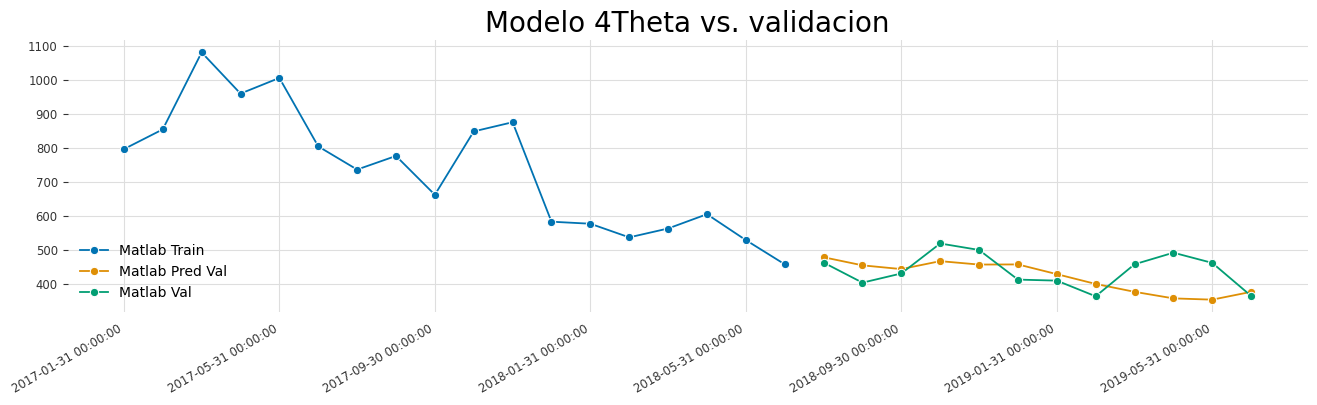

In [93]:
modelo=FourTheta(theta=best_grid_model[1]['theta'],
                 model_mode=ModelMode.MULTIPLICATIVE,
                 season_mode=SeasonalityMode.ADDITIVE,
                 trend_mode=TrendMode.EXPONENTIAL
                 )
modelo.fit(y_train_short_ts)
pred_modelo_4theta_val = modelo.predict(len(y_val_ts))

fig, ax = plot_series(y_train_short_ts.pd_series()["2017":],
                      pred_modelo_4theta_val.pd_series(),
                      y_val_ts.pd_series(),
                      labels=["Matlab Train", "Matlab Pred Val", "Matlab Val"])
fig.autofmt_xdate()
ax.legend(loc='lower left')
plt.title("Modelo 4Theta vs. validacion",fontsize=20);


Despues de graficar diferentes outputs del grid search, nos quedamos con esta ultima iteracion al ser la que mejor se comporta con el set de validacion, asi que usamos este mismo modelo para hacer nuestras predicciones en el conjunto de test.

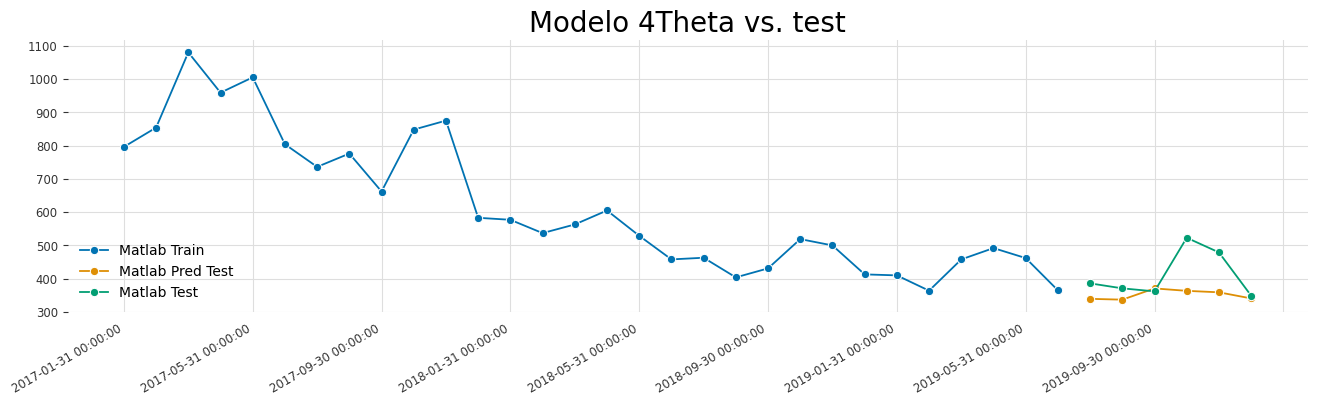

In [108]:
modelo.fit(y_train_ts)
pred_modelo_4theta_test = modelo.predict(len(y_test_ts))

fig, ax = plot_series(y_train_ts.pd_series()["2017":],
                      pred_modelo_4theta_test.pd_series(),
                      y_test_ts.pd_series(),
                      labels=["Matlab Train", "Matlab Pred Test", "Matlab Test"])
fig.autofmt_xdate()
ax.legend(loc='lower left')
plt.title("Modelo 4Theta vs. test",fontsize=20);

El modelo 4Theta parece ser el mas preciso en los primeros tres meses, clavando el tercer mes u el sexto. Sin embargo, es incapaz de reflejar la parte estacional del cuarto mes, lo que hace que su precision en estos meses sea pesima. 

In [111]:
from darts.metrics import mape as mape_theta,mae as mae_theta,rmse as rmse_theta,mse as mse_theta

MAPE_4THETA=mape_theta(y_test_ts, pred_modelo_4theta_test)/100
MSE_4THETA=mse_theta(y_test_ts, pred_modelo_4theta_test)
RMSE_4THETA=rmse_theta(y_test_ts, pred_modelo_4theta_test)

lista_4THETA = [MAPE_4THETA, MSE_4THETA, RMSE_4THETA]

### TBATS

In [95]:
model_tbats = TBATS(
use_box_cox=None,
box_cox_bounds=(0, 1),
use_trend=None,
use_damped_trend=None,
seasonal_periods="freq",
use_arma_errors=True,
show_warnings=False,
multiprocessing_start_method='spawn',
random_state=0)

model_tbats.fit(y_train_ts)

In [112]:
pred_modelo_tbats = model_tbats.predict(len(y_test_ts))

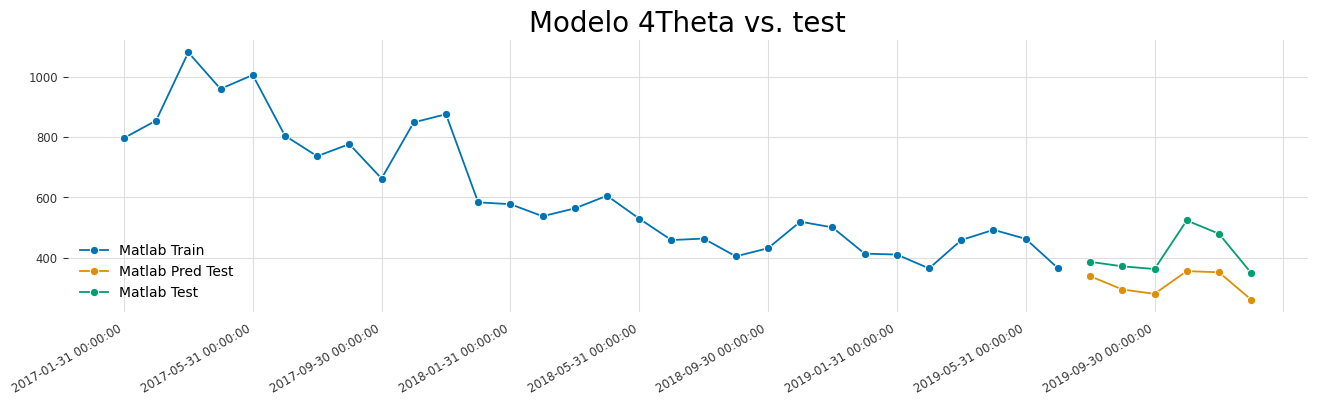

In [113]:

fig, ax = plot_series(y_train_ts.pd_series()["2017":],
                      pred_modelo_tbats.pd_series(),
                      y_test_ts.pd_series(),
                      labels=["Matlab Train", "Matlab Pred Test", "Matlab Test"])
fig.autofmt_xdate()
ax.legend(loc='lower left')
plt.title("Modelo 4Theta vs. test",fontsize=20);

Al modelo TBATS se le pueden poner todos los hiperparametros como "None". Esto hace que el modelo pruebe todas las posibles combinatorias para optimizar el resultado. <br>
Vemos que este modelo hace todo lo contrario al 4Theta. Es muy poco preciso con los primeros valores, pero predice mejor el comportamiento estacional. Sin embargo, al igual que el otros modelos, este se queda muy por debajo. 

In [114]:
MAPE_TBATS=mape_theta(y_test_ts, pred_modelo_tbats)/100
MSE_TBATS=mse_theta(y_test_ts, pred_modelo_tbats)
RMSE_TBATS=rmse_theta(y_test_ts, pred_modelo_tbats)

lista_TBATS = [MAPE_TBATS, MSE_TBATS, RMSE_TBATS]

In [115]:
tabla_errores=pd.DataFrame()
tabla_errores['Métrica'] = ['MAPE','MSE','RMSE']
tabla_errores=tabla_errores.set_index(tabla_errores['Métrica'])
tabla_errores=tabla_errores.drop(['Métrica'], axis=1)
tabla_errores['ETS'] = lista_ETS
tabla_errores['ARIMA Log'] = lista_ARIMA_LOG
tabla_errores['ARIMA Diffs']=lista_ARIMA_DIF
tabla_errores['4Theta']=lista_4THETA
tabla_errores['Tbats']=lista_TBATS
tabla_errores

,ETS,ARIMA Log,ARIMA Diffs,4Theta,Tbats
Métrica,,,,,
MAPE,0.162893,0.242484,0.146284,0.135849,0.233071
MSE,6680.594400,13243.140820,5102.012733,7209.765533,11208.344134
RMSE,81.734903,115.078846,71.428375,84.910338,105.869467


Para evaluar los modelos, he decido utilizado el MAPE, MSE y RMSE. El modelo ARIMA entrenado con las diferencias mensuales obtiene los mejores resultados por lo que lo utilizaremos para la siguiente pregunta. Pese a que el 4theta obtiene buenas metricas en comparacion al resto de modelos, se debe a que hace una casí una linea recta desde el ultimo punto y es casualidad que en los primeros tres meses coincide bastante. <br>
Por ultimo, todos los modelos que captan la parte estacional del modelo, se quedan por debajo en esos meses. Por eso, podemos decir que nuestro conjunto de test obtiene unos valores relativamente atipicos ya que estan por encima de cualquier prediccion.

### 4. Realizar una predicción de 12 meses fuera de la muestra.

In [139]:
forecaster_diff.fit(matlab_diff);

In [140]:
arima_diff_pred = forecaster_diff.predict(np.arange(1, 13))
arima_preds_diff = arima_diff_pred.squeeze().cumsum()+matlab["2019-12"].squeeze()

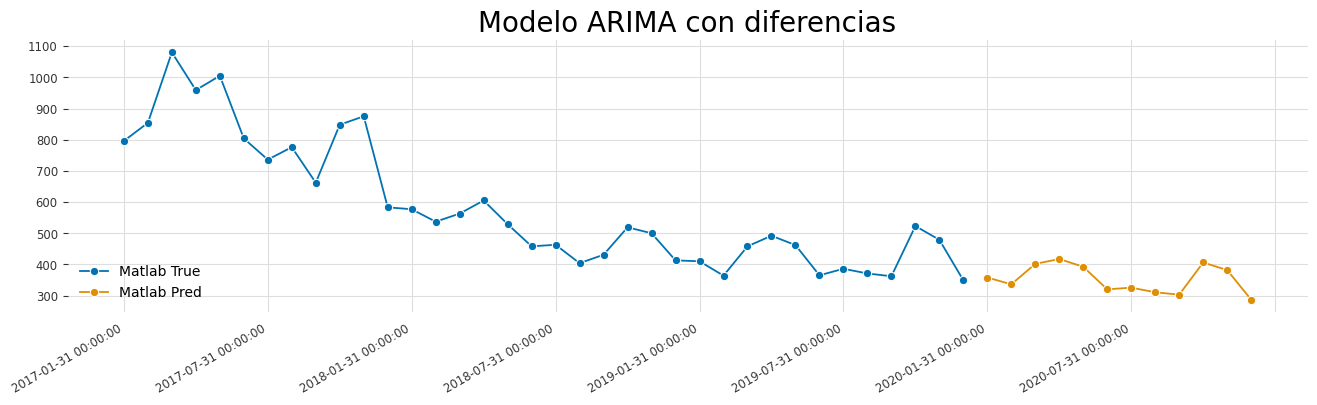

In [141]:
fig, ax = plot_series(matlab["2017-01":], arima_preds_diff, labels=["Matlab True", "Matlab Pred"])
fig.autofmt_xdate()
ax.legend(loc='lower left')
plt.title("Modelo ARIMA con diferencias",fontsize=20);

Realizamos una prediccion de un año fuera de la muestra con el modelo ARIMA basado en diferencias menuales. Observamos que mantiene la tendencia bajista y vemos como toma el patron de estacionalidad del ultimo año, donde los primeros meses aumentan con una forma de cupula y los ultimos meses aumentan de forma mas "cuadrada". 

In [150]:
!jupyter-nbconvert HW03_JuanSevillaFernandez.ipynb --no-input --no-prompt --to html
warnings.filterwarnings("ignore")

[NbConvertApp] Converting notebook HW03_JuanSevillaFernandez.ipynb to html
[NbConvertApp] Writing 1519709 bytes to HW03_JuanSevillaFernandez.html
